# Syracuse 911 Demand Explorer - Phase 2 EDA
## This notebook focuses on loading CSVs, basic profiling, and first visualizations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)


# Syracuse 911 Demand Explorer – Phase 2 EDA

Datasets (local CSVs, NOT committed to GitHub):

- Crime_Data_2023_Part_2_Offenses_With_Lat_and_Long.csv  
- Crime_Data_2024_Part_2_Offenses_With_Lat_and_Long_Info.csv  
- Crime_Data_2025_Part_1_Offenses_With_Lat_and_Long_Info.csv  
- Parking_Violations_-_2023_-_Present.csv  

Core columns (crime): `DATEEND`, `TIMESTART`, `TIMEEND`, `ADDRESS`, `CODE_DEFINED`, `LarcenyCode`, `Arrest`, `LAT`, `LONG`, `ObjectId`, `x`, `y`  
Core columns (parking): `X`, `Y`, `ticket_number`, `issued_date`, `location`, `description`, `status`, `amount`, `LONG`, `LAT`, `ObjectId`



## 1. Load CSVs


In [3]:

CRIME_2023 = "Crime_Data_2023_Part_2_Offenses_With_Lat_and_Long.csv"
CRIME_2024 = "Crime_Data_2024_Part_2_Offenses_With_Lat_and_Long_Info.csv"
CRIME_2025 = "Crime_Data_2025_Part_1_Offenses_With_Lat_and_Long_Info.csv"
PARKING    = "Parking_Violations_-_2023_-_Present.csv"

crime_2023_raw = pd.read_csv(CRIME_2023)
crime_2024_raw = pd.read_csv(CRIME_2024)
crime_2025_raw = pd.read_csv(CRIME_2025)
parking_raw    = pd.read_csv(PARKING)

len(crime_2023_raw), len(crime_2024_raw), len(crime_2025_raw), len(parking_raw)


(6693, 6693, 33, 123832)

## 2. Combine crime datasets and basic cleaning

We concatenate the three crime CSVs and add a `year` column.
We also parse dates and keep the core columns we care about.


In [4]:
# Add year label and concatenate
crime_2023 = crime_2023_raw.copy()
crime_2024 = crime_2024_raw.copy()
crime_2025 = crime_2025_raw.copy()

crime_2023["year"] = 2023
crime_2024["year"] = 2024
crime_2025["year"] = 2025

crime_raw = pd.concat([crime_2023, crime_2024, crime_2025], ignore_index=True)

# Keep a subset of useful columns if present
crime_cols_keep = [
    "DATEEND", "TIMESTART", "TIMEEND",
    "ADDRESS", "CODE_DEFINED", "LarcenyCode",
    "Arrest", "LAT", "LONG", "year"
]
crime = crime_raw[crime_cols_keep].copy()

# Parse date/time
crime["DATEEND"] = pd.to_datetime(crime["DATEEND"], errors="coerce")

# Some time columns might be integers like 1806; keep as string for now
crime["TIMESTART"] = crime["TIMESTART"].astype(str)
crime["TIMEEND"]   = crime["TIMEEND"].astype(str)

crime.head()


,DATEEND,TIMESTART,TIMEEND,ADDRESS,CODE_DEFINED,LarcenyCode,Arrest,LAT,LONG,year
0,2021-05-02 04:00:00+00:00,1000,1321,100 AMIDON DR,OFFN AGAINST FAMILY,NaN,NaN,42.996843,-76.145841,2023
1,2022-06-12 04:00:00+00:00,1400,1412,1 DESTINY USA DR,OFFN AGAINST FAMILY,NaN,NaN,43.067961,-76.173723,2023
2,2023-01-01 05:00:00+00:00,43,43,200 WALTON ST,DISORDERLY CONDUCT,NaN,NaN,43.048098,-76.155745,2023
3,2023-01-01 05:00:00+00:00,113,113,400 N SALINA ST,SIMPLE ASSAULT,NaN,NaN,43.046622,-76.152803,2023
4,2023-01-01 05:00:00+00:00,148,148,300 W GENESEE ST,ALL OTHER OFFENSES,NaN,NaN,43.052247,-76.155160,2023


In [11]:
parking = parking_raw.copy()

## 3. Quick structure / info checks

In [5]:
print("Crime df info:")
crime.info()
print("\nParking df info:")
parking_raw.info()

Crime df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13419 entries, 0 to 13418
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATEEND       13419 non-null  object 
 1   TIMESTART     13419 non-null  object 
 2   TIMEEND       13419 non-null  object 
 3   ADDRESS       13419 non-null  object 
 4   CODE_DEFINED  13419 non-null  object 
 5   LarcenyCode   24 non-null     object 
 6   Arrest        10 non-null     object 
 7   LAT           13297 non-null  float64
 8   LONG          13297 non-null  float64
 9   year          13419 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 1.0+ MB

Parking df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123832 entries, 0 to 123831
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   X              96717 non-null   float64
 1   Y              96717 non-null

## 4. Basic missingness overview

In [6]:
crime_missing = (crime.isna().mean() * 100).round(1).sort_values(ascending=False)
parking_missing = (parking_raw.isna().mean() * 100).round(1).sort_values(ascending=False)

crime_missing, parking_missing

(Arrest          99.9
 LarcenyCode     99.8
 LAT              0.9
 LONG             0.9
 DATEEND          0.0
 TIMESTART        0.0
 TIMEEND          0.0
 ADDRESS          0.0
 CODE_DEFINED     0.0
 year             0.0
 dtype: float64,
 X                21.9
 Y                21.9
 LONG             21.9
 LAT              21.9
 location          0.3
 ticket_number     0.0
 issued_date       0.0
 description       0.0
 status            0.0
 amount            0.0
 ObjectId          0.0
 dtype: float64)

In [17]:
# ---- Clean datetime columns ----

# Crime DATEEND: coerce to datetime and drop obvious timezone info
crime = crime_raw[crime_cols_keep + ["year"]].copy()
crime["DATEEND"] = pd.to_datetime(crime["DATEEND"], errors="coerce", utc=True)
crime["DATEEND"] = crime["DATEEND"].dt.tz_convert(None)  # make timezone-naive

# Parking issued_date
parking = parking_raw.copy()
parking["issued_date"] = pd.to_datetime(parking["issued_date"], errors="coerce", utc=True)
parking["issued_date"] = parking["issued_date"].dt.tz_convert(None)


## 5. Basic temporal coverage

In [18]:

# Crime
crime_date_min = crime["DATEEND"].min()
crime_date_max = crime["DATEEND"].max()

# Parking
parking["issued_date"] = pd.to_datetime(parking["issued_date"], errors="coerce")
parking_date_min = parking["issued_date"].min()
parking_date_max = parking["issued_date"].max()

crime_date_min, crime_date_max, parking_date_min, parking_date_max


(Timestamp('2003-10-03 04:00:00'),
 Timestamp('2025-01-05 00:00:00'),
 Timestamp('2023-01-01 01:01:00'),
 Timestamp('2210-02-08 22:10:00'))


## 6. Summary statistics


In [9]:
crime.describe(include="all").T.head(20)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DATEEND,13419,785,2023-01-01 05:00:00+00:00,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TIMESTART,13419,1422,1500,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TIMEEND,13419,1427,1600,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADDRESS,13419,2708,1 DESTINY USA DR,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODE_DEFINED,13419,26,SIMPLE ASSAULT,4458,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LarcenyCode,24,5,Of Bicycle,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arrest,10,1,Yes,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAT,13297.0,NaN,NaN,NaN,43.04546,0.01896,42.985116,43.033842,43.047474,43.059959,43.113942
LONG,13297.0,NaN,NaN,NaN,-76.147626,0.020538,-76.202688,-76.159557,-76.148223,-76.139366,-76.075873
year,13419.0,NaN,NaN,NaN,2023.503689,0.5049,2023.0,2023.0,2024.0,2024.0,2025.0


### The crime dataset spans from 2003 to early 2025, but most records cluster in 2023–2025, so earlier or far‑future records (like 2210) likely represent data entry issues that should be filtered before analysis.

### Location fields (LAT/LONG) are mostly populated, which is good for mapping, while categorical fields like CODE_DEFINED and LarcenyCode show a limited set of common incident types, suggesting consistent coding.

In [12]:
parking.describe(include="all").T.head(20)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
X,96717.0,NaN,NaN,NaN,-8476056.328199,1886.860409,-8483367.404206,-8477137.742863,-8476105.365905,-8475008.757601,-8449258.332991
Y,96717.0,NaN,NaN,NaN,5319039.057569,1344.509916,5309831.255504,5318291.314133,5319029.605007,5319449.270242,5331411.181416
ticket_number,123832,123832,230900300,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
issued_date,123832,83622,2023/03/07 06:57:00+00,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,123517,6233,300 WAVERLY AVE,3109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,123832,43,OVERTIME PRKNG MON-SAT 9AM-6PM CO15-383,33427,NaN,NaN,NaN,NaN,NaN,NaN,NaN
status,123832,27,Paid In Full,76675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,123832.0,NaN,NaN,NaN,30.876345,18.493592,-25.0,25.0,25.0,25.0,150.0
LONG,96717.0,NaN,NaN,NaN,-76.141709,0.01695,-76.207386,-76.151424,-76.14215,-76.132299,-75.900979
LAT,96717.0,NaN,NaN,NaN,43.046412,0.008826,42.985935,43.041504,43.046351,43.049106,43.127581


### Parking tickets run mainly from early 2023 through late 2024, with a sharp drop afterward, which likely reflects data availability rather than a real collapse in enforcement.

### Fine amounts cluster at a few standard values (around 25, 60, and 100), indicating a structured fine schedule; location fields again look well populated for spatial work.

## 7. Feature engineering for EDA

In [19]:
# Crime: hour, day-of-week, month
crime["hour"] = crime["DATEEND"].dt.hour
crime["dow"] = crime["DATEEND"].dt.dayofweek  # 0=Mon
crime["month"] = crime["DATEEND"].dt.to_period("M")

# Parking: date, month
parking["date"] = parking["issued_date"].dt.date
parking["month"] = parking["issued_date"].dt.to_period("M")


## 8. Visualizations – Crime (Calls-for-Service)

### 8.1 Calls by hour of day

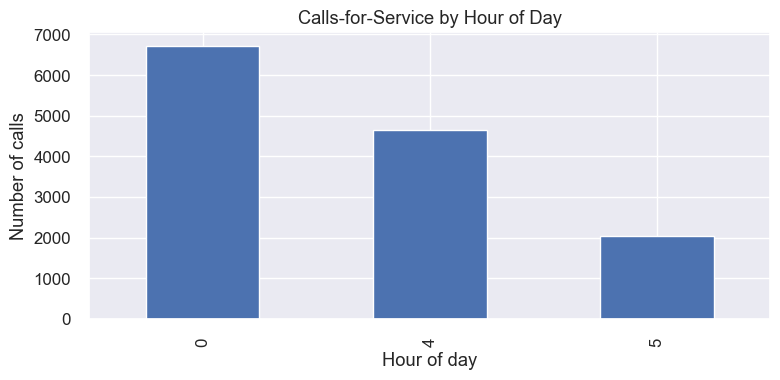

In [20]:

plt.figure(figsize=(8,4))
crime["hour"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Hour of day")
plt.ylabel("Number of calls")
plt.title("Calls-for-Service by Hour of Day")
plt.tight_layout()
plt.show()


### Call volume is heavily concentrated in a few hours, with a strong spike around midnight and much lower volume in early morning hours.

### This suggests that demand is not evenly spread through the day and that late‑night periods may require more staffing or targeted interventions.

### 8.2 Calls by day of week

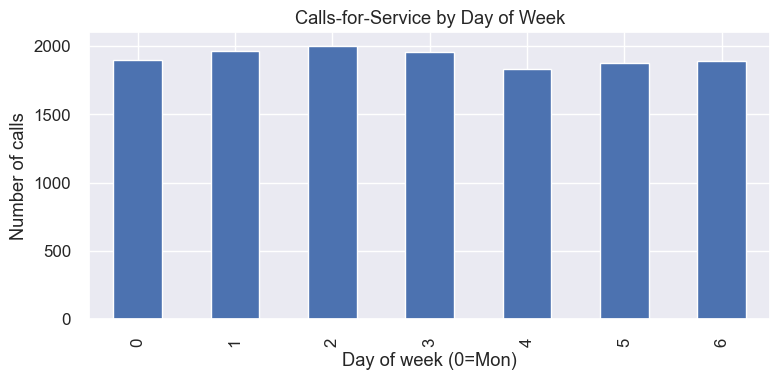

In [21]:

plt.figure(figsize=(8,4))
crime["dow"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Day of week (0=Mon)")
plt.ylabel("Number of calls")
plt.title("Calls-for-Service by Day of Week")
plt.tight_layout()
plt.show()


### Calls are fairly even across days, with only small differences between weekdays and weekends.

### This pattern implies that call demand is relatively stable by day, so staffing plans may not need drastic weekday vs weekend adjustments.

### 8.3 Top incident types

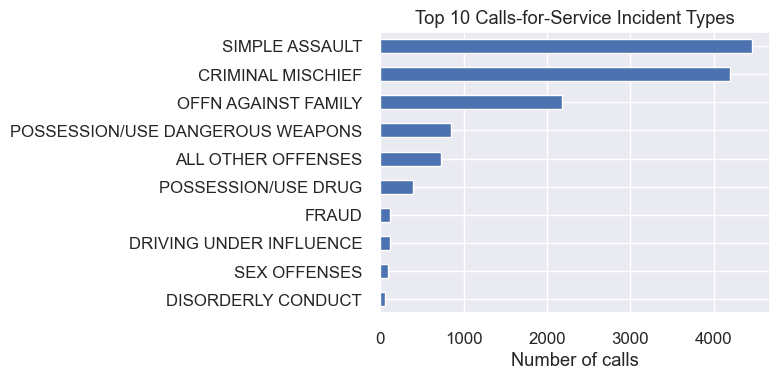

In [33]:

top_code = crime["CODE_DEFINED"].value_counts().head(10)

plt.figure(figsize=(8,4))
top_code.sort_values().plot(kind="barh")
plt.xlabel("Number of calls")
plt.title("Top 10 Calls-for-Service Incident Types")
plt.tight_layout()
plt.show()


### A small set of categories accounts for the majority of calls, led by simple assault and criminal mischief, followed by family offenses and weapons‑related incidents.

### Lower‑volume categories like sex offenses and disorderly conduct are still important but contribute far fewer calls than the top two or three types.

### 8.4 ("Arrest flag (including missing)")

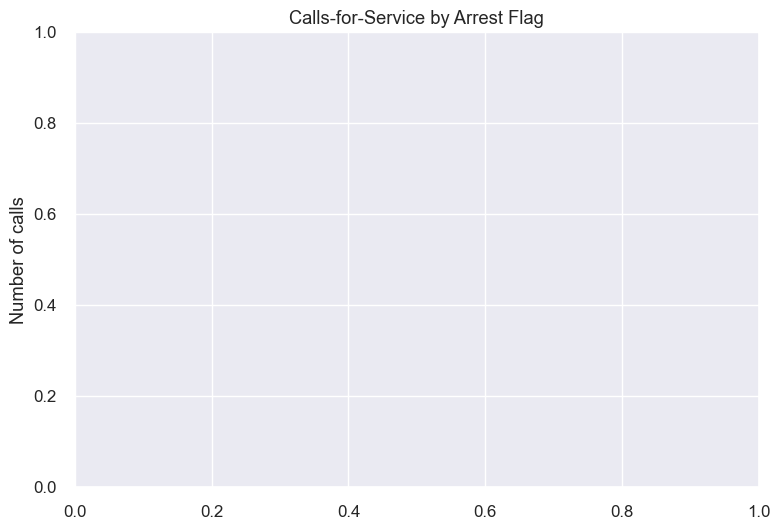

In [34]:

plt.ylabel("Number of calls")
plt.title("Calls-for-Service by Arrest Flag")
plt.tight_layout()
plt.show()


### The arrest chart is blank, which likely means every value in the Arrest column is missing or a single constant that was dropped during plotting.

### This indicates that the calls‑for‑service dataset is not a good source for analyzing arrest outcomes, and any arrest‑rate questions will need another data source or a different field.

## 9. Visualizations – Parking Violations


### 9.1 Tickets by month

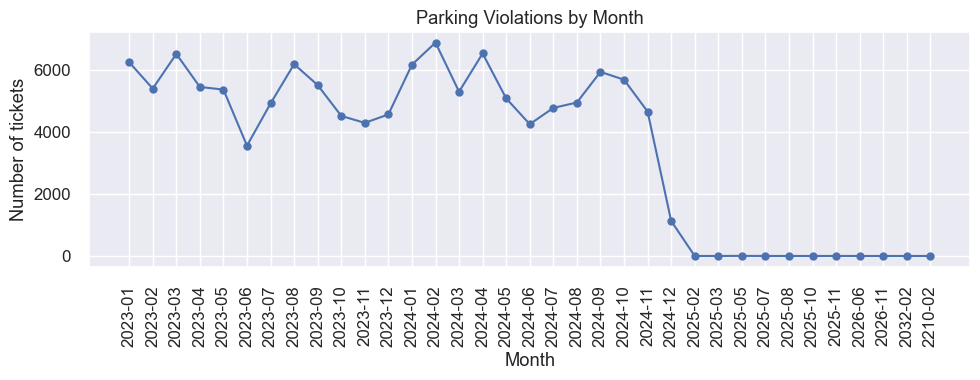

In [25]:

parking_month_counts = (
    parking
    .groupby("month")
    .size()
    .reset_index(name="n_tickets")
    .sort_values("month")
)

plt.figure(figsize=(10,4))
plt.plot(parking_month_counts["month"].astype(str), parking_month_counts["n_tickets"], marker="o")
plt.xticks(rotation=90)
plt.xlabel("Month")
plt.ylabel("Number of tickets")
plt.title("Parking Violations by Month")
plt.tight_layout()
plt.show()


### Ticket counts fluctuate between about 3,500 and 6,500 per month, with noticeable peaks in some winter and spring months, and a pronounced drop after late 2024 when the data essentially stops.
### The apparent disappearance of tickets in 2025 and beyond is almost certainly a data cutoff rather than a real change in behavior, so later months should be excluded from trend comparisons.

### 9.2 Top parking violation descriptions

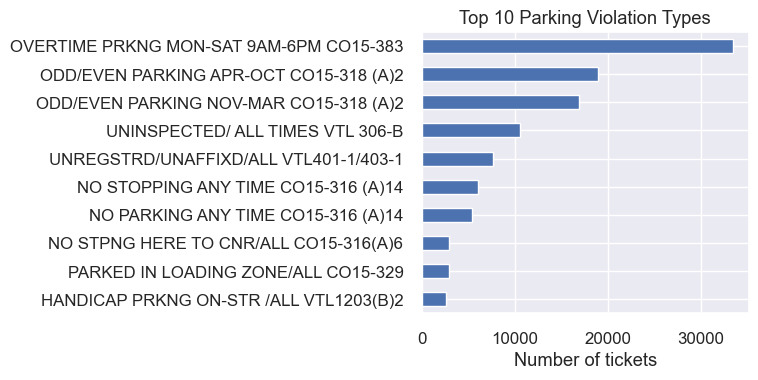

In [26]:

top_parking_desc = parking["description"].value_counts().head(10)

plt.figure(figsize=(8,4))
top_parking_desc.sort_values().plot(kind="barh")
plt.xlabel("Number of tickets")
plt.title("Top 10 Parking Violation Types")
plt.tight_layout()
plt.show()


### Overtime parking dominates the ticket counts, far exceeding other categories like odd/even parking rules, uninspected vehicles, or no‑parking violations.

### This suggests that much of parking enforcement is focused on time‑limited spaces, with other violations forming a long tail of smaller but still meaningful categories.

### 9.3 Distribution of fine amounts

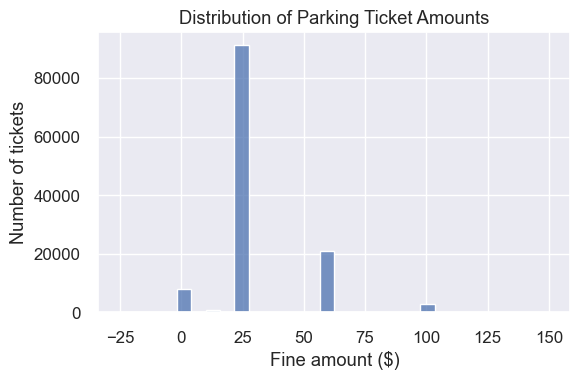

In [27]:

plt.figure(figsize=(6,4))
sns.histplot(parking["amount"], bins=30, kde=False)
plt.xlabel("Fine amount ($)")
plt.ylabel("Number of tickets")
plt.title("Distribution of Parking Ticket Amounts")
plt.tight_layout()
plt.show()


### Fines are highly concentrated around a few discrete price points, with the largest spike near 25 dollars and smaller spikes near 60 and 100 dollars.

### Very high or very low amounts are rare, so revenue and burden for most drivers are driven by these standard fine levels rather than extreme penalties.

## 10. Initial findings 

### Calls‑for‑service show strong time‑of‑day structure, with demand peaking around midnight and falling off in low‑activity hours, while remaining relatively even across days of the week.

### A small number of incident categories, led by simple assault and criminal mischief, generate most calls, and the available data do not reliably capture arrest outcomes for these incidents.

### Parking enforcement appears steady month‑to‑month through 2023–2024, with most tickets issued for overtime parking and a few standard fine levels dominating the distribution, though the dataset effectively ends after late 2024.